In [1]:
from main import * 
from exp_runner import * 
from utils import *
import pandas as pd
import numpy as np
from time import perf_counter
import seaborn as sn
import matplotlib.pyplot as plt

## Preguntas a responder:
- ¿Cuántos niveles de servidores DNS se recorrieron en las sucesivas consultas hasta obtener la información solicitada? 
- ¿Todos los servidores DNS Autoritativos que aparecen en las sucesivas respuestas responden a las consultas realizadas?
- ¿Cuántos nombres de servidores de mail encontraron?, ¿Tienen nombres en el mismo dominio que la universidad?
- ¿Cuántas direcciones IP distintas hay? ¿Estas direcciones IP corresponden a dispositivos que están prendidos? (Hint: probar con ping si responden)
- ¿Coinciden las IPs de los servidores de correo con las IPs de los servidores Web?

### Funciones para el dataframe

In [2]:
sdfm = SuperDataFrameMonolitico()

sdfm.create_reduce_col("leaves", get_leaves)
sdfm.create_reduce_col("avg_leaf_depth", average_leaf_depth)
sdfm.create_reduce_col("soa_qty", soa_qty)

In [3]:
sdfm.df

jobname  root_server_ip           url  \
0     dolmedo_prod   198.97.190.53       uvic.ca   
1     dolmedo_prod     192.33.4.12   uatf.edu.bo   
2     dolmedo_prod  192.203.230.10    anu.edu.au   
3     dolmedo_prod     192.33.4.12  unmsm.edu.pe   
4     dolmedo_prod      198.41.0.4      ox.ac.uk   
..             ...             ...           ...   
567  frosende_prod   198.97.190.53        usp.br   
568  frosende_prod    193.0.14.129       ethz.ch   
569  frosende_prod    202.12.27.33       uvic.ca   
570  frosende_prod   198.97.190.53      ox.ac.uk   
571  frosende_prod     192.33.4.12       uvic.ca   

                                     scanner_object  \
0    <scanner.FullScanner object at 0x7fd1541c24a8>   
1    <scanner.FullScanner object at 0x7fd1541da2b0>   
2    <scanner.FullScanner object at 0x7fd15409f940>   
3    <scanner.FullScanner object at 0x7fd153ff8978>   
4    <scanner.FullScanner object at 0x7fd153d77d68>   
..                                              ...   
567  <scanner.FullScanner object at 0x7fd13011a4e0>   
568  <scanner.FullScanner object at 0x7fd130078400>   
569  <scanner.FullScanner object at 0x7fd12fe42240>   
570  <scanner.FullScanner object at 0x7fd12fdce7f0>   
571  <scanner.FullScanner object at 0x7fd12fd0ff28>   

                                                leaves  avg_leaf_depth  \
0    [(<scanner.FullScanner object at 0x7fd1541da35...        2.800000   
1    [(<scanner.FullScanner object at 0x7fd15409f9e...        2.727273   
2    [(<scanner.FullScanner object at 0x7fd153ff8a9...        3.535354   
3    [(<scanner.FullScanner object at 0x7fd153d77e1...        2.600000   
4    [(<scanner.FullScanner object at 0x7fd153d2e66...        2.000000   
..                                                 ...             ...   
567  [(<scanner.FullScanner object at 0x7fd13007851...        2.916667   
568  [(<scanner.FullScanner object at 0x7fd12fe4239...        2.769231   
569  [(<scanner.FullScanner object at 0x7fd12fdce89...        2.705882   
570  [(<scanner.FullScanner object at 0x7fd12fd0ff6...        2.000000   
571  [(<scanner.FullScanner object at 0x7fd12fc6212...        2.705882   

     soa_qty  
0          0  
1          0  
2          0  
3          0  
4          0  
..       ...  
567        0  
568        0  
569        0  
570        0  
571        0  

[572 rows x 7 columns]

In [89]:
df = sdfm.df.copy()

COUNTRY_URLS = {
    'ARGENTINA': "exactas.uba.ar",
    'BOLIVIA': "uatf.edu.bo",
    'PERU': "unmsm.edu.pe",
    'BRASIL': "usp.br",
    'CANADA': "uvic.ca",
    'UK': "ox.ac.uk",
    'SUIZA': "ethz.ch",
    'RUSIA': "msu.ru",
    'ISRAEL': "technion.ac.il",
    'CHINA': "tsinghua.edu.cn",
    'AUSTRALIA': "anu.edu.au",
}

def match_url(url):
    for country in COUNTRY_URLS.keys():
        if COUNTRY_URLS[country] == url:
            return country

### Presentacion

## Fede estuvo aquí

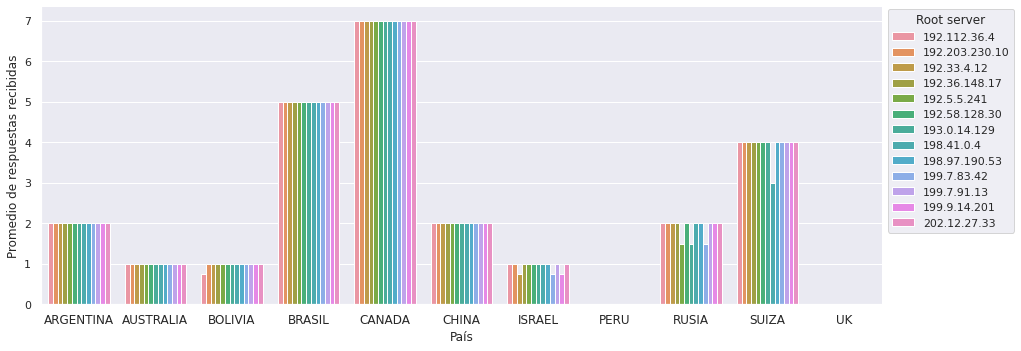

In [80]:
sn.set()
df = sdfm.df.copy()
df['url'] = [match_url(url) for url in df['url']]
lens = [len(scn.final_answer) for scn in df.scanner_object]
df['ans_len'] = lens
df = df.groupby(['url', 'root_server_ip']).mean().reset_index()
sn.catplot(x='url', y='ans_len', hue='root_server_ip', data=df, kind='bar', legend=False)
plt.xlabel('País')
plt.ylabel('Promedio de respuestas recibidas')
plt.legend(title='Root server', bbox_to_anchor=(1, 1.01))
ax = plt.gcf()
plt.gca().tick_params(axis="x", labelsize=12)
ax.set_size_inches(14, 5) 

Text(0.5, 1.0, 'Distribución de profundidad de hojas')

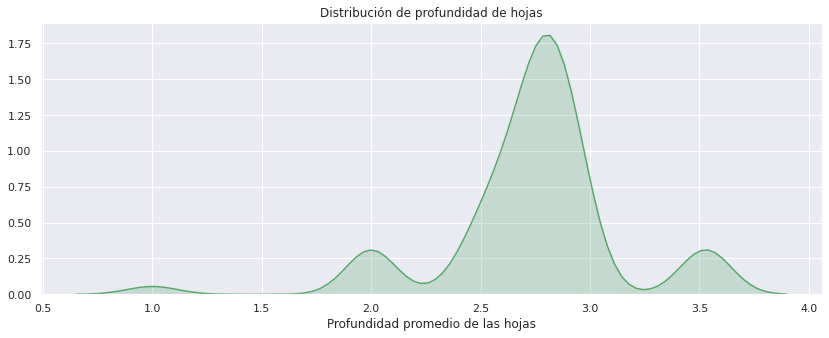

In [6]:
df = sdfm.df.copy()
ax = plt.gca()
d = df['avg_leaf_depth']
sn.distplot(d, hist=False, color="g", kde_kws={"shade": True}, ax=ax)
ax.figure.set_size_inches(14,5)
plt.xlabel('Profundidad promedio de las hojas')
plt.title('Distribución de profundidad de hojas')

In [90]:
import pydot
from printable_scanner_node import * 
import networkx as nx

df = sdfm.df.copy()
#scn = df['scanner_object'][5] #5 está bueno, 1 está bueno, 4 está buenísimo, 14  
scn = list(df.groupby('jobname').get_group('dolmedo_prod')['scanner_object'])[11]

print(scn.url)
root = PrintableScannerNode(scn.server_ip, scn)

root._create_printable_tree()

def walk_tree(graph, printable_node, father_ip=None, father=None):
    if not ":" in str(printable_node.ip):
        shape = 'ellipse'
        from_label = str(printable_node.ip)
        if father:
            color = '#fd8c59'
            if len(printable_node.childs) == 0:
                color = '#fdd49e'
                shape = 'box'
                if printable_node.sn.has_a_mail_exchange_answer():
                    from_label = from_label + '\n' + " ".join(printable_node.sn.final_answer)
            from_name = str(printable_node.ip) + str(father_ip)
            node_from = pydot.Node(from_name, color=color, style='filled', label=from_label, shape=shape)
            graph.add_node(node_from)
            graph.add_edge(pydot.Edge(father, node_from))
        else:      
            from_name = str(printable_node.ip)
            node_from = pydot.Node(from_name, color='#ef6548', style='filled', label=from_label, shape=shape)
            node_from.set_height('"1"')
            node_from.set_width('"1"')                
            graph.add_node(node_from)
        for child in printable_node.childs:
            walk_tree(graph, child, printable_node.ip, node_from)

def plot_tree(root, name):

    # first you create a new graph, you do that with pydot.Dot()
    graph = pydot.Dot(graph_type='graph', size = "13, 13", labelloc="t",label="Árbol explorado para la universidad de " + match_url(root.url) + " con servidor " + root.server_ip)

    walk_tree(graph, root)

    graph.write_png(name+'.png')

plot_tree(root,'tree')

msu.ru


AttributeError: 'PrintableScannerNode' object has no attribute 'url'

In [75]:
list(df.groupby('jobname').get_group('dolmedo_prod')['scanner_object'])[0]

In [8]:
df = sdfm.df.copy()
grouped_df = df.groupby('url')
answers_by_url = {}
for url, df_url in grouped_df:
    total_ans = set()
    for leaves in df_url['leaves']:
        ans = set()
        for leaf in leaves:
            ip = leaf[0].server_ip
            if not ':' in ip and leaf[0].has_a_mail_exchange_answer():
                ans.add(leaf[0].server_ip)
        total_ans = total_ans.union(ans)
    answers_by_url[url] = total_ans
answers_by_url

{'anu.edu.au': {'129.127.40.3', '150.203.1.10', '150.203.22.28'},
 'ethz.ch': {'129.132.250.8', '129.132.98.8', '130.59.31.29'},
 'exactas.uba.ar': {'157.92.1.1', '157.92.4.1'},
 'msu.ru': {'93.180.0.1'},
 'ox.ac.uk': set(),
 'technion.ac.il': {'132.68.1.2', '132.68.1.9', '132.68.238.50'},
 'tsinghua.edu.cn': {'202.112.0.13', '202.38.109.35'},
 'uatf.edu.bo': {'181.115.147.162'},
 'unmsm.edu.pe': set(),
 'usp.br': {'143.107.253.8',
  '143.107.51.8',
  '143.108.30.90',
  '200.133.38.221',
  '200.144.248.208',
  '200.144.249.208'},
 'uvic.ca': {'142.104.6.1', '142.104.80.2', '206.12.58.50', '206.12.58.52'}}

### Vemos si algún webserver coincide con los encontrados en las hojas

In [9]:
for url, ans in answers_by_url.items():
    ip = get_info(url)['query']
    print(url, ip, ip in ans)

anu.edu.au 130.56.66.152 False
ethz.ch 129.132.19.216 False
exactas.uba.ar 157.92.32.18 False
msu.ru 188.44.50.103 False
ox.ac.uk 129.67.242.154 False
technion.ac.il 132.68.239.58 False
tsinghua.edu.cn tsinghua.edu.cn False
uatf.edu.bo 181.115.147.162 True
unmsm.edu.pe 200.62.146.14 False
usp.br 200.144.248.41 False
uvic.ca 142.104.197.120 False


## Roni

In [9]:
def initial_plot(df, url, ips):
    def get_quant(df, ip):
        return sum(len(scanner.final_answer) for scanner in df[df.root_server_ip == ip].scanner_object)/len(set(df.jobname))
        
    url_df = df[df.url == url]
    url_dict = {ip: get_quant(url_df, ip) for ip in ips}
    return url_dict

rootserverips = set(df.root_server_ip)
urls = set(df.url)
initial_plot_dict = [initial_plot(df, url, rootserverips) for url in urls]

In [10]:
initial_plot_df = pd.DataFrame(initial_plot_dict, index=urls)
initial_plot_df.index = [match_url(url) for url in initial_plot_df.index]

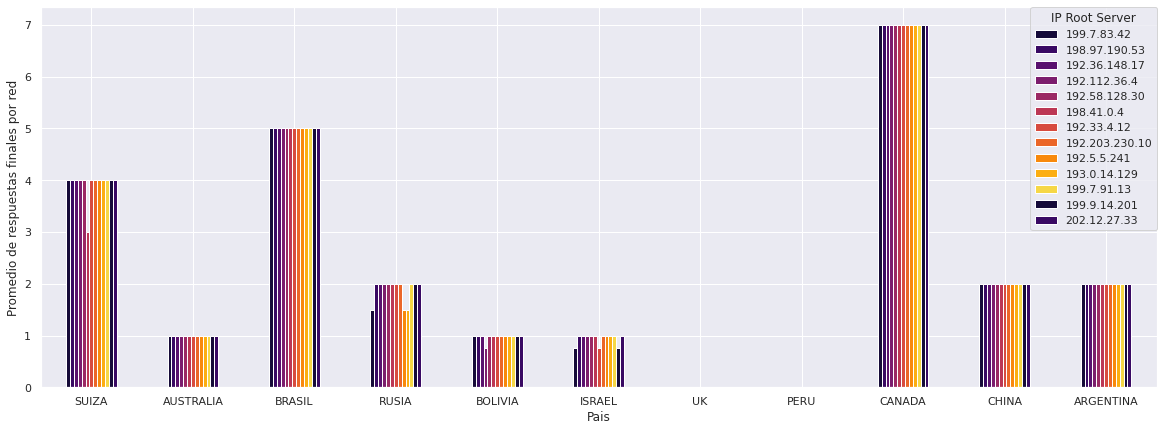

In [47]:
import numpy as np
from matplotlib import cm
colors = cm.inferno(np.linspace(.10, .90, len(initial_plot_df.index)))
sn.set()

fig, ax1 = plt.subplots(1, 1, figsize=(20,7))
initial_plot_df.plot.bar(rot=0, ax=ax1, color=colors)
plt.xlabel('Pais')
plt.ylabel('Promedio de respuestas finales por red')
plt.legend(title='IP Root Server', bbox_to_anchor=(1.0, 1.0), loc='best', borderaxespad=0.)

plt.show()

In [12]:
# Descartamos lo que no sirve
unuseful = ['PERU', 'UK']
df['country'] = df.url.apply(match_url)
with_data_df = df[~df.country.isin(unuseful)]
with_data_df = with_data_df[with_data_df.scanner_object.apply(lambda x: ipv4(x.server_ip))]

In [13]:
def create_np_array_with_leaves_vals(df):
    url_dfs = df.groupby('url')
    mins = []
    maxes = []
    means = []
    countries = []
    for url, url_df in url_dfs:
        heights = np.array([height for leaves in url_df.leaves for scanner, height in leaves if ipv4(scanner.server_ip)])
        mins.append(heights.min(0))
        maxes.append(heights.max(0))
        means.append(heights.mean(0))
        countries.append(match_url(url))
    return np.array(mins), np.array(maxes), np.array(means), countries

x1_mins, x1_maxes, x1_means, x1_labels = create_np_array_with_leaves_vals(with_data_df)

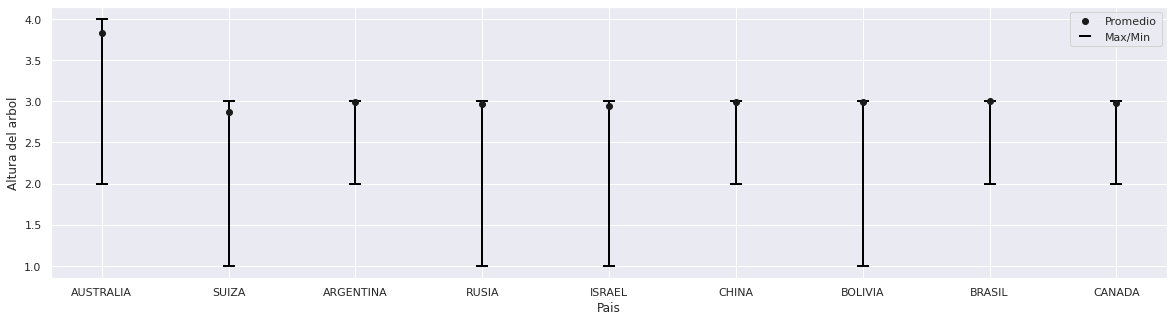

In [92]:
fig, ax1 = plt.subplots(1, 1, figsize=(20,5))
x1_x = np.arange(len(x1_mins))
plt.errorbar(x1_x, x1_means, [x1_means - x1_mins, x1_maxes - x1_means],
             fmt='ok', ecolor='black', lw=2, capsize=6, capthick=2, marker='o', label="label")
ax1.set_xticks(x1_x)
ax1.set_xticklabels(x1_labels)
handles, labels = ax1.get_legend_handles_labels()
handles = handles[0]
ax1.legend(handles, ["Promedio", "Max/Min"], loc='best', numpoints=1)
ax1.set_xlabel("Pais")
ax1.set_ylabel("Altura del arbol")
plt.show()

# Dante

In [85]:
def getDifferentIps(df, url, ips):
    def getIpList(df,ip):
        result_ips=[]
        for scanner in df[df.root_server_ip == ip].scanner_object:
            result_ips=result_ips+get_ipv4_list(scanner)
        return result_ips
    url_df = df[df.url == url]
    response=[]
    for ip in ips:
        response=response+getIpList(url_df,ip)
    new_response=[b for b in response if b not in ips]
    return new_response
    
    
everyIp = [getDifferentIps(df, url, rootserverips) for url in urls]
flat_list = [item for sublist in everyIp for item in sublist]

In [86]:
everyIp = {url:len(list(set(getDifferentIps(df, url, rootserverips)))) for url in urls}
print(everyIp.keys())

dict_keys(['ethz.ch', 'anu.edu.au', 'usp.br', 'msu.ru', 'uatf.edu.bo', 'technion.ac.il', 'ox.ac.uk', 'unmsm.edu.pe', 'uvic.ca', 'tsinghua.edu.cn', 'exactas.uba.ar'])


Text(12.335000000000008, 0.5, 'Cantidad de ips distintas visitadas')

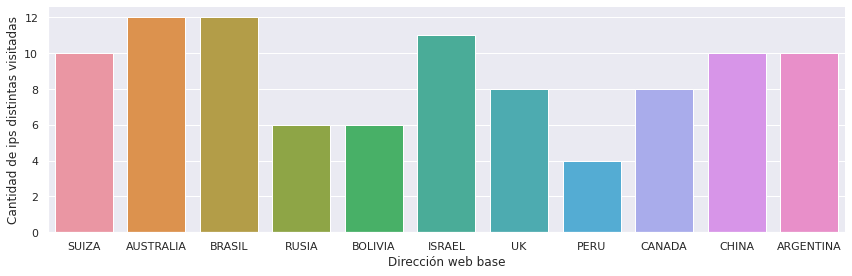

In [91]:
ipdf = pd.DataFrame({'x':list(everyIp.keys()),'y':list(everyIp.values()),'url':list(urls)})

ipdf['x'] = [match_url(url) for url in ipdf['url']]

sn.set()
sn.catplot(x='x', y='y', data=ipdf,height=4, aspect=3, kind='bar', legend=False)
plt.xlabel('Dirección web base')
plt.ylabel('Cantidad de ips distintas visitadas')
#plt.legend(bbox_to_anchor=(1.01, 1.3), loc='best', borderaxespad=0.)

In [20]:
full_list=list(set(flat_list))
count=0
for ip in full_list:
    if(ping(ip)):
        count=count+1

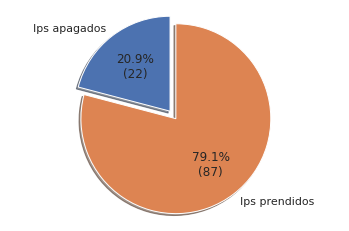

In [21]:
def func(pct, allvals):
    absolute = int(pct/100.*np.sum(allvals))
    return "{:.1f}%\n({:d})".format(pct, absolute)

labels = 'Ips apagados','Ips prendidos'
sizes = [len(full_list)-count, count]
explode = (0, 0.1)

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct=lambda pct: func(pct, sizes),
        shadow=True, startangle=90)
ax1.axis('equal') 

plt.show()

In [22]:
def getDifferentAnswers(df, url, ips):
    def getAnswerList(df,ip):
        result_ips=[]
        for scanner in df[df.root_server_ip == ip].scanner_object:
            result_ips=result_ips+get_answer_list(scanner)
        return result_ips
    url_df = df[df.url == url]
    response=[]
    for ip in ips:
        response=response+getAnswerList(url_df,ip)
    return response

In [23]:
everyIp2 = [list(set(getDifferentAnswers(df, url, rootserverips))) for url in urls]
flat_list2 = [item for sublist in everyIp2 for item in sublist]

In [24]:
count2=[ping(direction) for direction in flat_list2]

In [26]:
countdf=pd.DataFrame(list(zip(flat_list2, count2)), 
               columns =['Direccion mx', 'Respondio']) 

In [27]:
countdf

Direccion mx  Respondio
0                                  b'mc3.ethz.ch.'      False
1                                  b'mc2.ethz.ch.'      False
2                                  b'mc4.ethz.ch.'      False
3                                  b'mc1.ethz.ch.'      False
4                      b'ALT1.ASPMX.L.GOOGLE.COM.'       True
5                           b'ASPMX.L.GOOGLE.COM.'       True
6                      b'ALT3.ASPMX.L.GOOGLE.COM.'       True
7                      b'ALT4.ASPMX.L.GOOGLE.COM.'       True
8                      b'ALT2.ASPMX.L.GOOGLE.COM.'       True
9                              b'mail.anu.edu.au.'      False
10                               b'smtpr.uvic.ca.'       True
11                               b'smtpu.uvic.ca.'       True
12                               b'smtpz.uvic.ca.'       True
13                               b'smtpy.uvic.ca.'       True
14                               b'smtps.uvic.ca.'       True
15                               b'smtpv.uvic.ca.'       True
16                               b'smtpw.uvic.ca.'       True
17                        b'mta0.tsinghua.edu.cn.'       True
18                        b'mta1.tsinghua.edu.cn.'       True
19  b'technion-ac-il.mail.protection.outlook.com.'      False
20                            b'mta2.fcen.uba.ar.'       True
21                            b'mta3.fcen.uba.ar.'       True
22                                   b'mx.msu.ru.'       True
23                                  b'nss.msu.ru.'       True
24                            b'mail.uatf.edu.bo.'      False